In [5]:
import pandas as pd
import pickle
import numpy as np
from numpy import sort

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils import shuffle, resample

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import os

import warnings
warnings.filterwarnings('ignore')

In [6]:
DATA_PATH = 'data'

# Load Data

In [22]:
def load_data(filename,balance=False):
    df = pd.read_csv(os.path.join(DATA_PATH, filename))
    df = shuffle(df)

    if balance == True:
        df_majority = df[df['RC_FLAG'] == 0]
        df_minority = df[df['RC_FLAG'] == 1]
        
        df_majority_downsampled = resample(df_majority,replace=False,n_samples=len(df_minority),random_state=123)

        df = pd.concat([df_majority_downsampled, df_minority])

#     X = df[[
# #       'TPV_6M',
# #       'TS',
# #       'COVER_DAY_6M',
# #       'PT_FIX_SPEED_UL_COVER_6M',
# #       'TOTAL_MONTH',
# #       'SOF_OTHER_FREQ_6M',
# #       'PT_FIX_SPEED_NS_COVER_6M',
# #       'V_CODE_6M'
#         'TS',
#         'TPV_6M',
#         'COVER_DAY_6M',
#         'PT_FIX_SPEED_UL_COVER_6M',
#         'V_CODE_6M',
#         'SOF_OTHER_FREQ_6M',
        
        
#         'CH_WEB_FREQ_6M',
#         'SOF_WALLET_FREQ_6M',
#     ]]        
    X = df.drop(['RC_FLAG','TARGET_MONTH','MOBILE'],axis=1)
    y = df[['RC_FLAG']]
    return X, y

In [23]:
X,y = load_data('NEW_RC_6M.csv',True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42)

In [25]:
print(X_train.shape)
print(X_test.shape)

(401246, 40)
(100312, 40)


In [26]:
y_train['RC_FLAG'].value_counts()

1    200699
0    200547
Name: RC_FLAG, dtype: int64

# Random Oversampling and Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
# oversample = RandomUnderSampler(sampling_strategy='majority')
over = RandomOverSampler(sampling_strategy=0.2)
X_sam, y_sam = over.fit_resample(X_train, y_train)

under = RandomUnderSampler(sampling_strategy='majority')
X_sam, y_sam = under.fit_resample(X_sam, y_sam)

In [ ]:
y_sam['RC_FLAG'].value_counts()

# SMOTE

In [547]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_sam, y_sam = oversample.fit_resample(X_train, y_train)

In [548]:
sample_df = pd.concat([X_sam,y_sam],axis=1)
sample_df.to_csv('data/SAMPLE_NEW_RC.csv',index=False)

In [549]:
y_sam['RC_FLAG'].value_counts()

1    1868388
0    1868388
Name: RC_FLAG, dtype: int64

# Xgboost Model

In [27]:
model = xgb.XGBClassifier(importance_type='weight')
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='weight', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
pred_prob = model.predict_proba(X_test)

In [29]:
acc = accuracy_score(y_test, predictions)
f1_acc = f1_score(y_test, predictions)

In [30]:
print('ACCURACY :', acc)
print('F1 SCORE :', f1_acc)

ACCURACY : 0.6138547731079034
F1 SCORE : 0.6327287208321085


In [ ]:
model = xgb.XGBClassifier(verbosity = 0,importance_type="weight")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc_score = accuracy_score(y_test,y_pred)
print("Accuracy: %.2f%%" % (acc_score * 100))

import numpy as np
thresh = np.sort(model.feature_importances_)

for t in thresh:
    select = SelectFromModel(model,threshold=t,prefit=True)
    select_xtrain = select.transform(X_train)

    select_model = xgb.XGBClassifier(verbosity = 0)
    select_model.fit(select_xtrain,y_train)

    select_xtest = select.transform(X_test)
    y_pred_new = select_model.predict(select_xtest)
    z = [round(value) for value in y_pred_new]
    acc_score = accuracy_score(y_test,z)
    pre_score = precision_score(y_test,z)
    rec_score = recall_score(y_test,z)
    f_score = f1_score(y_test, z)

    print('Thresh=%.3f, n=%d, Accuracy: %.2f%% F-Score: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (t,select_xtest.shape[1],acc_score*100,f_score*100,pre_score,rec_score))

In [31]:
importances = list(zip(model.feature_importances_, X_train))
importances.sort(reverse=True)
print('Feature,Score')
for item in importances[:9]:
    print(','.join([str(item[1]), str(item[0])]))

Feature,Score
TPV_6M,0.10261194
TS,0.09411277
COVER_DAY_6M,0.056799337
PT_FIX_SPEED_UL_COVER_6M,0.047263682
V_CODE_6M,0.039386403
SOF_OTHER_FREQ_6M,0.037935324
PT_FIX_SPEED_UL_FREQ_6M,0.037728027
CH_WEB_FREQ_6M,0.037728027
CH_WALLET_FREQ_6M,0.03731343


# Confusion Matrix

In [580]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

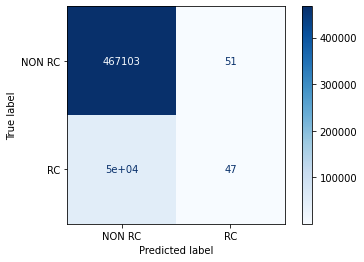

In [581]:
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=['NON RC', 'RC'],
                             cmap=plt.cm.Blues,)

In [582]:
confusion_matrix(y_test, y_pred)

array([[467103,     51],
       [ 50064,     47]])

In [583]:
disp.confusion_matrix

array([[467103,     51],
       [ 50064,     47]])

# ROC AUC

In [584]:
from sklearn.metrics import plot_roc_curve

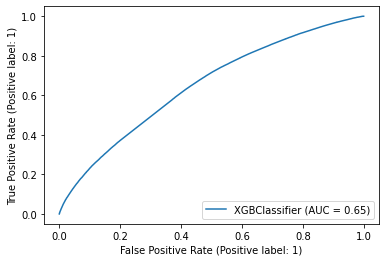

In [585]:
plot_roc_curve(model, X_test, y_test) 

# Lift Chart

In [586]:
import scikitplot as skplt

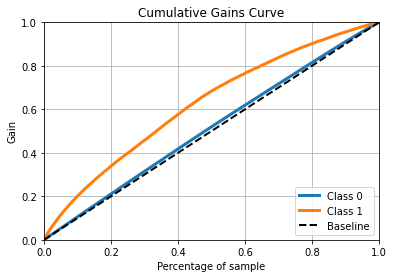

In [587]:
skplt.metrics.plot_cumulative_gain(y_test, pred_prob)
plt.show()

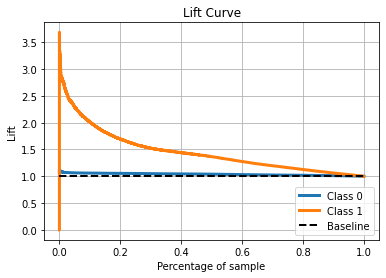

In [588]:
skplt.metrics.plot_lift_curve(y_test, pred_prob)
plt.show()

# Save model

In [589]:
model.save_model('model_result/new_rc_unbalance.json')

# Evaluate

In [590]:
X_eval, y_eval = load_data('NEW_RC_JAN21.csv')

In [591]:
X_eval.shape

(6194035, 8)

In [592]:
y_eval['RC_FLAG'].value_counts()

0    6112533
1      81502
Name: RC_FLAG, dtype: int64

In [593]:
X_eval.shape

(6194035, 8)

In [594]:
bst = xgb.Booster({'nthread': 4})
bst.load_model('model_result/new_rc_unbalance.json')

In [595]:
pred = model.predict(X_eval)
predictions_eval = np.array([round(value) for value in pred])

In [596]:
acc = accuracy_score(y_eval, predictions_eval)
f1_acc = f1_score(y_eval, predictions_eval)

In [597]:
print('ACCURACY :', acc)
print('F1 SCORE :', f1_acc)

ACCURACY : 0.9867690447341676
F1 SCORE : 0.00168106126128321


In [598]:
print(np.count_nonzero(predictions_eval == 0))
print(np.count_nonzero(predictions_eval == 1))

6193446
589


In [599]:
confusion_matrix(y_eval, predictions_eval)

array([[6112013,     520],
       [  81433,      69]])

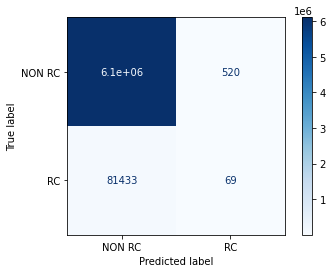

In [600]:
disp = plot_confusion_matrix(model, X_eval, y_eval,
                             display_labels=['NON RC', 'RC'],
                             cmap=plt.cm.Blues,)

In [601]:
disp.confusion_matrix

array([[6112013,     520],
       [  81433,      69]])

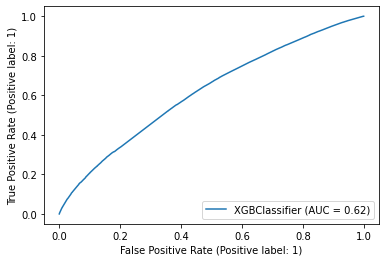

In [602]:
plot_roc_curve(model, X_eval, y_eval) 

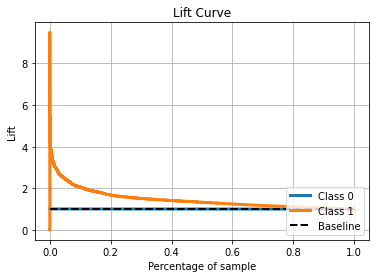

In [603]:
prob_result = model.predict_proba(X_eval)
skplt.metrics.plot_lift_curve(y_eval, prob_result)
plt.show()

# Prob predict

In [ ]:
prob_result = model.predict_proba(X_eval)
df_eval = pd.concat([X_eval, y_eval],axis=1)
df_eval['PROB'] = prob_result[:,1:]

In [ ]:
df_eval.head()

In [ ]:
df_eval.to_csv(os.path.join(DATA_PATH, 'new_rc_result.csv'))

# Feb Prediction

In [206]:
feb_df = pd.read_csv(os.path.join(DATA_PATH, 'feb_tmn_test.csv'))

In [207]:
data_df = feb_df[[
        'TS',
        'RC_RECENCY',
        'TPV_6M',
        'COVER_DAY_6M',
]]

In [208]:
bst = xgb.Booster({'nthread': 4})
bst.load_model('new_vas_rc_xgb.json')

In [209]:
prob_result = model.predict_proba(data_df)

In [210]:
feb_df['PROB'] = prob_result[:,1:]

In [179]:
feb_df.to_csv(os.path.join(DATA_PATH, 'rc_feb_result.csv'),index=False)